# Hyperparameter Tuning untuk Model GRU Prediksi Harga Saham LQ45 (PyTorch & GPU)

In [ ]:
# 1. Import Libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import warnings
from datetime import timedelta
import os

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

warnings.filterwarnings('ignore')

# 2. Parameter, Inisialisasi, dan Setup Device

In [ ]:
# 2. Parameter, Inisialisasi, dan Setup Device

# --- Parameter Data ---
KODE_INDEKS = '^JKLQ45'
PERIODE_AWAL = '2005-01-01'
PERIODE_AKHIR = '2025-05-27' # Sesuaikan dengan tanggal data terakhir yang valid
N_FEATURES = 1 # Hanya 'Close'

# --- Hyperparameter untuk Tuning ---
WINDOW_SIZES_TO_TUNE = [5, 10]
# Untuk PyTorch GRU, HIDDEN_SIZE_GRU akan jadi list dari hidden_dim per layer
GRU_UNITS_PYTORCH = [64, 32] # Jumlah unit untuk setiap layer GRU
DENSE_UNITS_PYTORCH = 16
DROPOUT_RATE_PYTORCH = 0.2
BATCH_SIZES_TO_TUNE = [8, 16, 32, 64]
EPOCHS_SETTINGS_TO_TUNE = [100, 150, 200]
LEARNING_RATES_TO_TUNE = [0.001, 0.0001]
OUTPUT_SIZE = 1 # Output size untuk prediksi harga saham

# --- Hyperparameter Training PyTorch ---
PATIENCE_EARLY_STOPPING = 30 #
PATIENCE_LR_SCHEDULER = 20   #

# --- Split Ratios ---
TRAIN_RATIO = 0.7
VAL_RATIO = 0.2

# DataFrame untuk menyimpan hasil tuning (Kolom Disederhanakan)
results_list_pt = []
COLUMNS_PT_SIMPLE = [
    'learning_rate', 'window_size', 'batch_size', 'epochs_set',
    'test_rmse', 'test_mape' # Hanya Test RMSE dan Test MAPE
]

# Direktori untuk menyimpan model dan plot
output_dir_pt = "tuning_outputs_pytorch"
if not os.path.exists(output_dir_pt):
    os.makedirs(output_dir_pt)
print(f"Output PyTorch akan disimpan di direktori: {output_dir_pt}")

# Tentukan device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Menggunakan device: {device}")
if torch.cuda.is_available():
    print(f"Device name: {torch.cuda.get_device_name(0)}")

Output PyTorch akan disimpan di direktori: tuning_outputs_pytorch
Menggunakan device: cuda
Device name: NVIDIA GeForce RTX 3060 Laptop GPU


## 3. Fungsi-Fungsi Bantuan (Data dan Model PyTorch)

In [ ]:
# 3.1. Fungsi Persiapan Data untuk PyTorch
def prepare_data_pytorch(kode_indeks, periode_awal, periode_akhir, window_size_param, train_ratio, val_ratio):
    print(f"  Mengunduh data untuk window_size: {window_size_param} (PyTorch)...")
    lq45_all_cols = yf.download(kode_indeks, start=periode_awal, end=periode_akhir, progress=False)
    if lq45_all_cols.empty:
        raise ValueError("Gagal mengunduh data yfinance")

    lq45 = lq45_all_cols[['Close']].copy()
    lq45.dropna(inplace=True)

    train_s = int(len(lq45) * train_ratio)
    val_s = int(len(lq45) * val_ratio)

    train_data_df = lq45.iloc[:train_s]
    val_data_df = lq45.iloc[train_s : train_s + val_s]
    test_data_df = lq45.iloc[train_s + val_s :]

    scaler_obj = MinMaxScaler(feature_range=(0, 1))
    train_scaled = scaler_obj.fit_transform(train_data_df[['Close']])
    val_scaled = scaler_obj.transform(val_data_df[['Close']])
    test_scaled = scaler_obj.transform(test_data_df[['Close']])

    # generate_sequence_pytorch dari kode sebelumnya
    def generate_sequence_pt(data_scaled, window_size):
        x, y = [], []
        for i in range(len(data_scaled) - window_size):
            sequence = data_scaled[i:(i + window_size), 0]
            target = data_scaled[i + window_size, 0]
            x.append(sequence)
            y.append(target)
        return np.array(x).reshape(-1, window_size, 1), np.array(y).reshape(-1, 1)

    x_train_seq, y_train_seq = generate_sequence_pt(train_scaled, window_size_param)
    x_val_seq, y_val_seq = generate_sequence_pt(val_scaled, window_size_param)
    x_test_seq, y_test_seq = generate_sequence_pt(test_scaled, window_size_param)

    return (
        x_train_seq, y_train_seq,
        x_val_seq, y_val_seq,
        x_test_seq, y_test_seq,
        scaler_obj,
        train_data_df, val_data_df, test_data_df # Index original untuk plotting
    )

# PyTorch Dataset
class StockDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [ ]:
# 3.2. Fungsi Pembuatan Model PyTorch
class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_gru_dims_list, hidden_dense_dim, output_dim, dropout_p):
        super(GRUNet, self).__init__()

        self.grus = nn.ModuleList()
        self.layer_norms_gru = nn.ModuleList()
        self.dropouts_gru = nn.ModuleList()

        current_input_dim = input_dim
        for i, h_dim in enumerate(hidden_gru_dims_list):
            # Hanya layer GRU terakhir yang tidak return sequence penuh untuk diteruskan ke Dense
            # Di PyTorch, ini berarti kita ambil output hidden state terakhir dari GRU terakhir
            is_last_gru_in_stack = (i == len(hidden_gru_dims_list) - 1)

            self.grus.append(nn.GRU(current_input_dim, h_dim, batch_first=True, num_layers=1))
            # LayerNorm setelah setiap GRU (mirip BatchNormalization di Keras pada output sekuensial)
            self.layer_norms_gru.append(nn.LayerNorm(h_dim))
            self.dropouts_gru.append(nn.Dropout(dropout_p if not is_last_gru_in_stack else dropout_p / 2))
            current_input_dim = h_dim # Untuk GRU berikutnya

        self.fc1 = nn.Linear(hidden_gru_dims_list[-1], hidden_dense_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dense_dim, output_dim)

    def forward(self, x):
        # x shape: (batch_size, seq_length, input_dim)
        for i in range(len(self.grus)):
            gru_out, _ = self.grus[i](x) # gru_out: (batch, seq_len, hidden_dim_gru_i)

            if i < len(self.grus) - 1: # Jika bukan GRU terakhir dalam tumpukan GRU
                out_normalized = self.layer_norms_gru[i](gru_out) # LayerNorm pada output sekuens
                x = self.dropouts_gru[i](out_normalized)
            else: # GRU terakhir sebelum Dense layer
                out_last_step = gru_out[:, -1, :] # Ambil output dari time step terakhir
                out_normalized = self.layer_norms_gru[i](out_last_step) # LayerNorm pada output ini
                x = self.dropouts_gru[i](out_normalized)

        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

def create_pytorch_model(window_size_param, learning_rate_param, gru_units_pt_list, dense_units_pt_val, dropout_pt_rate, n_features_param):
    model_pt = GRUNet(
        input_dim=n_features_param,
        hidden_gru_dims_list=gru_units_pt_list,
        hidden_dense_dim=dense_units_pt_val,
        output_dim=OUTPUT_SIZE,
        dropout_p=dropout_pt_rate
    ).to(device)

    criterion_pt = nn.HuberLoss()
    optimizer_pt = torch.optim.Adam(model_pt.parameters(), lr=learning_rate_param)
    scheduler_pt = ReduceLROnPlateau(optimizer_pt,
                                    mode='min', # 'min' untuk memantau loss, 'max' untuk accuracy
                                    patience=PATIENCE_LR_SCHEDULER,
                                    factor=0.2,
                                    min_lr=0.00001) # Hapus verbose=False
    return model_pt, criterion_pt, optimizer_pt, scheduler_pt

In [ ]:
# 3.3. Fungsi Evaluasi Model PyTorch
def evaluate_model_metrics_pt(y_true, y_pred):
    y_true_1d = y_true.flatten()
    y_pred_1d = y_pred.flatten()

    mse = mean_squared_error(y_true_1d, y_pred_1d)
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(y_true_1d, y_pred_1d)
    mask = y_true_1d != 0
    if np.sum(mask) == 0:
        mape = np.nan
    else:
        mape = np.mean(np.abs((y_true_1d[mask] - y_pred_1d[mask]) / y_true_1d[mask])) * 100
    return rmse, mae, mape

In [ ]:
# Cell 8: Loop Utama Hyperparameter Tuning (PyTorch)

for lr_val_pt in LEARNING_RATES_TO_TUNE:
    for ws_val_pt in WINDOW_SIZES_TO_TUNE:
        (
            x_train_pt, y_train_pt,
            x_val_pt, y_val_pt,
            x_test_pt, y_test_pt,
            scaler_obj_pt,
            train_df_pt, val_df_pt, test_df_pt
        ) = prepare_data_pytorch(KODE_INDEKS, PERIODE_AWAL, PERIODE_AKHIR, ws_val_pt, TRAIN_RATIO, VAL_RATIO)

        train_dataset_pt = StockDataset(x_train_pt, y_train_pt)
        val_dataset_pt = StockDataset(x_val_pt, y_val_pt)
        test_dataset_pt = StockDataset(x_test_pt, y_test_pt)

        for bs_val_pt in BATCH_SIZES_TO_TUNE:
            current_train_loader = DataLoader(train_dataset_pt, batch_size=bs_val_pt, shuffle=True)
            current_val_loader = DataLoader(val_dataset_pt, batch_size=bs_val_pt, shuffle=False)
            current_test_loader = DataLoader(test_dataset_pt, batch_size=bs_val_pt, shuffle=False)

            for ep_val_set_pt in EPOCHS_SETTINGS_TO_TUNE:
                print(f"\n--- Melatih dengan Parameter (PyTorch) ---")
                print(f"Window Size: {ws_val_pt}, Batch Size: {bs_val_pt}, Epochs Set: {ep_val_set_pt}, Learning Rate: {lr_val_pt}")

                model_pt, criterion_pt, optimizer_pt, scheduler_pt = create_pytorch_model(
                    ws_val_pt, lr_val_pt, GRU_UNITS_PYTORCH, DENSE_UNITS_PYTORCH, DROPOUT_RATE_PYTORCH, N_FEATURES
                )

                best_val_loss_pt = float('inf')
                epochs_no_improve_pt = 0
                train_losses_iter, val_losses_iter = [], []
                actual_epochs_trained_pt = 0 # Akan diupdate berdasarkan epoch terbaik jika early stopping
                best_epoch_for_this_run = 0

                model_save_filename_pt = os.path.join(output_dir_pt, f'best_model_pt_w{ws_val_pt}_b{bs_val_pt}_e{ep_val_set_pt}_lr{str(lr_val_pt).replace(".", "")}.pth')

                for epoch in range(ep_val_set_pt):
                    # --- Training per epoch ---
                    model_pt.train()
                    running_train_loss = 0.0
                    for batch_features, batch_labels in current_train_loader:
                        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
                        optimizer_pt.zero_grad()
                        outputs = model_pt(batch_features)
                        loss = criterion_pt(outputs, batch_labels)
                        loss.backward()
                        optimizer_pt.step()
                        running_train_loss += loss.item() * batch_features.size(0)
                    epoch_train_loss = running_train_loss / len(current_train_loader.dataset)
                    train_losses_iter.append(epoch_train_loss)

                    # --- Validasi per epoch ---
                    model_pt.eval()
                    running_val_loss = 0.0
                    with torch.no_grad():
                        for batch_features, batch_labels in current_val_loader:
                            batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
                            outputs = model_pt(batch_features)
                            loss = criterion_pt(outputs, batch_labels)
                            running_val_loss += loss.item() * batch_features.size(0)
                    epoch_val_loss = running_val_loss / len(current_val_loader.dataset)
                    val_losses_iter.append(epoch_val_loss)

                    if epoch % 10 == 0 or epoch == ep_val_set_pt -1 :
                        print(f"  Epoch {epoch+1}/{ep_val_set_pt} => Train Loss: {epoch_train_loss:.6f}, Val Loss: {epoch_val_loss:.6f}")

                    scheduler_pt.step(epoch_val_loss)

                    if epoch_val_loss < best_val_loss_pt:
                        best_val_loss_pt = epoch_val_loss
                        torch.save(model_pt.state_dict(), model_save_filename_pt)
                        epochs_no_improve_pt = 0
                        best_epoch_for_this_run = epoch + 1
                    else:
                        epochs_no_improve_pt += 1

                    if epochs_no_improve_pt >= PATIENCE_EARLY_STOPPING:
                        print(f"  Early stopping. Epoch terbaik: {best_epoch_for_this_run}, Val Loss: {best_val_loss_pt:.6f}")
                        actual_epochs_trained_pt = best_epoch_for_this_run # Catat epoch terbaik
                        break

                # Jika tidak early stopping, epoch terbaik adalah epoch terakhir yang dijalankan
                if epochs_no_improve_pt < PATIENCE_EARLY_STOPPING:
                    actual_epochs_trained_pt = ep_val_set_pt # atau epoch + 1 jika loop selesai normal
                    if best_epoch_for_this_run == 0: # Jika tidak ada improvement sama sekali
                        best_epoch_for_this_run = ep_val_set_pt # anggap epoch terakhir
                        actual_epochs_trained_pt = best_epoch_for_this_run
                    else: # Jika ada improvement, actual_epochs_trained_pt adalah best_epoch_for_this_run
                        actual_epochs_trained_pt = best_epoch_for_this_run


                # Muat model terbaik yang disimpan
                model_pt.load_state_dict(torch.load(model_save_filename_pt))

                # === EVALUATE_LOADER UNTUK TEST SET DI SINI ===
                # Definisikan ulang evaluate_loader jika belum ada di scope ini atau panggil dari cell sebelumnya
                def evaluate_loader(loader, model_to_eval, device_to_eval, scaler_to_eval):
                    model_to_eval.eval()
                    preds_scaled, acts_scaled = [], []
                    with torch.no_grad():
                        for feat, lab in loader:
                            feat = feat.to(device_to_eval)
                            out = model_to_eval(feat)
                            preds_scaled.extend(out.cpu().numpy())
                            acts_scaled.extend(lab.numpy()) # lab sudah di CPU dari DataLoader
                    preds_unscaled = scaler_to_eval.inverse_transform(np.array(preds_scaled))
                    acts_unscaled = scaler_to_eval.inverse_transform(np.array(acts_scaled))
                    return acts_unscaled, preds_unscaled

                y_test_actual_pt, y_test_pred_pt = evaluate_loader(current_test_loader, model_pt, device, scaler_obj_pt)

                # Hitung metrik untuk test set
                # Pastikan fungsi evaluate_model_metrics_pt sudah didefinisikan di cell sebelumnya
                test_rmse, test_mae_val, test_mape_val = evaluate_model_metrics_pt(y_test_actual_pt, y_test_pred_pt)

                current_result_pt = {
                    'learning_rate': lr_val_pt,
                    'window_size': ws_val_pt,
                    'batch_size': bs_val_pt,
                    'epochs_set': ep_val_set_pt,
                    'test_rmse': test_rmse,
                    'test_mape': test_mape_val
                }
                results_list_pt.append(current_result_pt)
                print(f"  Hasil (PyTorch): Test RMSE: {test_rmse:.2f}, Test MAPE: {test_mape_val:.2f}%, Epochs Trained (best): {actual_epochs_trained_pt}")

                results_df_intermediate_pt = pd.DataFrame(results_list_pt, columns=COLUMNS_PT_SIMPLE)
                results_df_intermediate_pt.to_csv(os.path.join(output_dir_pt, 'gru_pytorch_tuning_results_simple.csv'), index=False)

                plt.figure(figsize=(10, 5))
                plt.plot(train_losses_iter, label='Train Loss')
                plt.plot(val_losses_iter, label='Validation Loss')
                # Update judul plot untuk mencerminkan epoch terbaik
                plt.title(f'Loss PT (w={ws_val_pt},b={bs_val_pt},e_set={ep_val_set_pt},lr={lr_val_pt}) BestEpoch:{actual_epochs_trained_pt}')
                plt.xlabel('Epoch')
                plt.ylabel('Loss (Huber)')
                plt.legend()
                plt.grid(True)
                plt.savefig(os.path.join(output_dir_pt, f'loss_plot_pt_w{ws_val_pt}_b{bs_val_pt}_e{ep_val_set_pt}_lr{str(lr_val_pt).replace(".", "")}.png'))
                plt.close()

                del model_pt
                torch.cuda.empty_cache()

results_df_final_pt = pd.DataFrame(results_list_pt, columns=COLUMNS_PT_SIMPLE)

  Mengunduh data untuk window_size: 5 (PyTorch)...

--- Melatih dengan Parameter (PyTorch) ---
Window Size: 5, Batch Size: 8, Epochs Set: 100, Learning Rate: 0.001
  Epoch 1/100 => Train Loss: 0.005671, Val Loss: 0.000282
  Epoch 11/100 => Train Loss: 0.000488, Val Loss: 0.000696
  Epoch 21/100 => Train Loss: 0.000325, Val Loss: 0.001111
  Epoch 31/100 => Train Loss: 0.000141, Val Loss: 0.000737
  Early stopping. Epoch terbaik: 6, Val Loss: 0.000224
  Hasil (PyTorch): Test RMSE: 14.17, Test MAPE: 1.26%, Epochs Trained (best): 6

--- Melatih dengan Parameter (PyTorch) ---
Window Size: 5, Batch Size: 8, Epochs Set: 150, Learning Rate: 0.001
  Epoch 1/150 => Train Loss: 0.003803, Val Loss: 0.001870
  Epoch 11/150 => Train Loss: 0.000477, Val Loss: 0.000423
  Epoch 21/150 => Train Loss: 0.000311, Val Loss: 0.000575
  Epoch 31/150 => Train Loss: 0.000191, Val Loss: 0.000597
  Epoch 41/150 => Train Loss: 0.000144, Val Loss: 0.000351
  Epoch 51/150 => Train Loss: 0.000159, Val Loss: 0.000763


## 5. Analisis Hasil Tuning (PyTorch)

In [ ]:
print("\n--- Hasil Akhir Hyperparameter Tuning (PyTorch - Simple) ---")
if not results_df_final_pt.empty:
    # Urutkan berdasarkan test_rmse terbaik (terkecil) karena val_rmse tidak disimpan
    results_df_sorted_pt = results_df_final_pt.sort_values('test_rmse')
    print(results_df_sorted_pt)

    best_params_row_pt = results_df_sorted_pt.iloc[0]
    print("\n--- Parameter Model Terbaik (PyTorch) Berdasarkan Test RMSE ---")
    print(f"Learning Rate  : {best_params_row_pt['learning_rate']}")
    print(f"Window Size    : {best_params_row_pt['window_size']}")
    print(f"Batch Size     : {best_params_row_pt['batch_size']}")
    print(f"Epochs Set     : {best_params_row_pt['epochs_set']}")
    # 'actual_epochs_trained' tidak disimpan di CSV sederhana ini, bisa ditambahkan jika perlu
    print("\n--- Metrik Model Terbaik (PyTorch) ---")
    print(f"Test RMSE : {best_params_row_pt['test_rmse']:.2f}")
    print(f"Test MAPE : {best_params_row_pt['test_mape']:.2f}%")

    results_df_sorted_pt.to_csv(os.path.join(output_dir_pt, 'gru_pytorch_tuning_results_simple_sorted.csv'), index=False)
else:
    print("Tidak ada hasil tuning PyTorch untuk ditampilkan.")


--- Hasil Akhir Hyperparameter Tuning (PyTorch - Simple) ---
    learning_rate  window_size  batch_size  epochs_set  test_rmse  test_mape
2          0.0010            5           8         200   9.801390   0.840887
3          0.0010            5          16         100   9.892324   0.864976
15         0.0010           10          16         100  10.736767   0.950933
18         0.0010           10          32         100  11.024389   0.978892
38         0.0001           10           8         200  11.526309   1.029271
22         0.0010           10          64         150  12.602544   1.135396
14         0.0010           10           8         200  13.003672   1.204579
9          0.0010            5          64         100  13.054867   1.167247
4          0.0010            5          16         150  13.634787   1.212623
21         0.0010           10          64         100  13.731702   1.261389
30         0.0001            5          32         100  13.734811   1.217210
35         0.0

## 6. Visualisasi Prediksi dengan Model Terbaik (PyTorch - Opsional)


Memuat ulang data untuk model terbaik PyTorch dengan window_size: 5
  Mengunduh data untuk window_size: 5 (PyTorch)...
Memuat model terbaik PyTorch dari file: tuning_outputs_pytorch\best_model_pt_w5_b8_e200_lr0001.pth


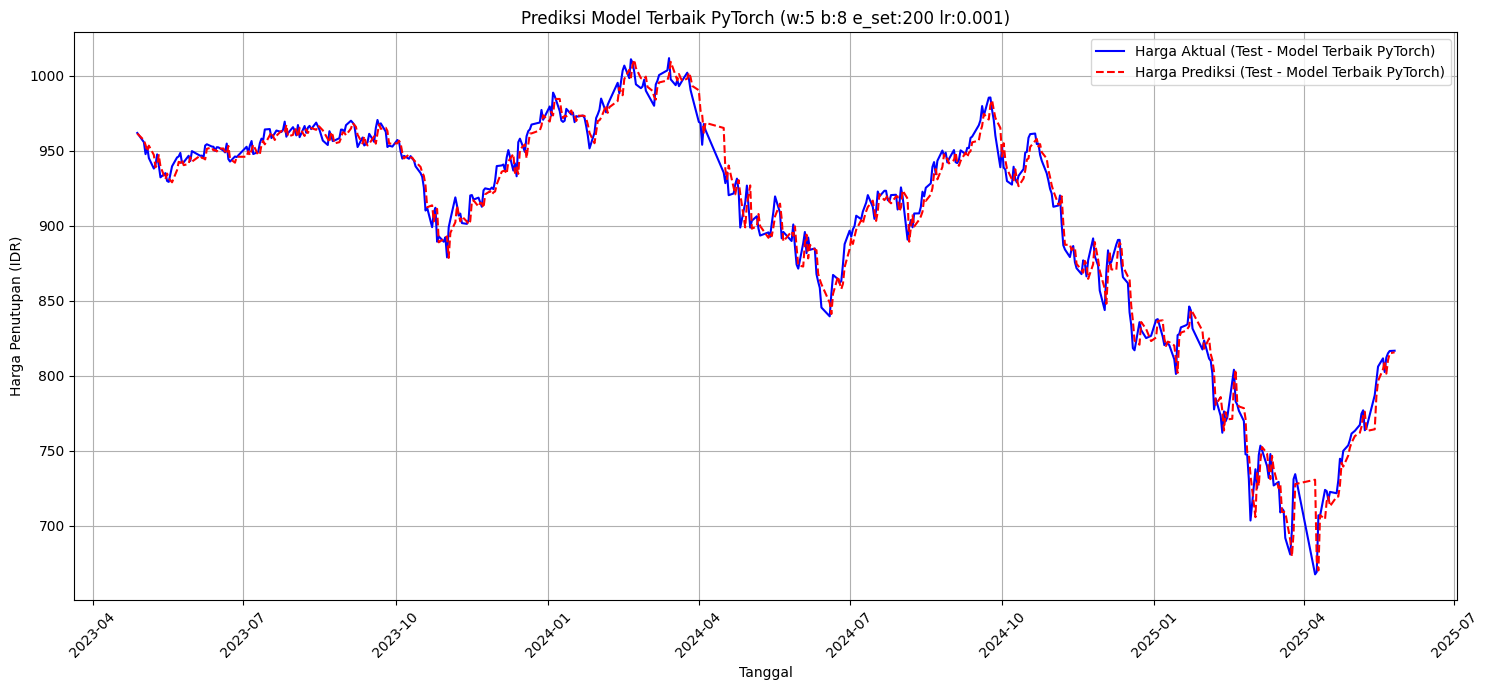

In [ ]:
# Contoh: Memvisualisasikan model terbaik jika diperlukan
if not results_df_final_pt.empty:
    best_ws_pt = int(best_params_row_pt['window_size'])
    best_bs_pt = int(best_params_row_pt['batch_size'])
    best_ep_set_pt = int(best_params_row_pt['epochs_set'])
    best_lr_pt = best_params_row_pt['learning_rate']

    print(f"\nMemuat ulang data untuk model terbaik PyTorch dengan window_size: {best_ws_pt}")
    (
        x_train_best_pt, y_train_best_pt,
        x_val_best_pt, y_val_best_pt,
        x_test_best_pt, y_test_best_pt,
        scaler_best_pt,
        train_df_best_pt, val_df_best_pt, test_df_best_pt
    ) = prepare_data_pytorch(KODE_INDEKS, PERIODE_AWAL, PERIODE_AKHIR, best_ws_pt, TRAIN_RATIO, VAL_RATIO)

    # Buat DataLoader untuk data test
    test_dataset_best_pt = StockDataset(x_test_best_pt, y_test_best_pt)
    test_loader_best_pt = DataLoader(test_dataset_best_pt, batch_size=best_bs_pt, shuffle=False) # Gunakan best_bs

    best_model_filename_pt = os.path.join(output_dir_pt, f'best_model_pt_w{best_ws_pt}_b{best_bs_pt}_e{best_ep_set_pt}_lr{str(best_lr_pt).replace(".", "")}.pth')
    print(f"Memuat model terbaik PyTorch dari file: {best_model_filename_pt}")

    if os.path.exists(best_model_filename_pt):
        final_best_model_pt, _, _, _ = create_pytorch_model(
            best_ws_pt, best_lr_pt, GRU_UNITS_PYTORCH, DENSE_UNITS_PYTORCH, DROPOUT_RATE_PYTORCH, N_FEATURES
        )
        final_best_model_pt.load_state_dict(torch.load(best_model_filename_pt))
        final_best_model_pt.to(device) # Pastikan model di device yang benar

        y_test_actual_unscaled_best_pt, y_test_pred_unscaled_best_pt = evaluate_loader(test_loader_best_pt, final_best_model_pt, device, scaler_best_pt)

        plt.figure(figsize=(15, 7))
        plt.plot(test_df_best_pt.index[best_ws_pt:], y_test_actual_unscaled_best_pt, label='Harga Aktual (Test - Model Terbaik PyTorch)', color='blue')
        plt.plot(test_df_best_pt.index[best_ws_pt:], y_test_pred_unscaled_best_pt, label='Harga Prediksi (Test - Model Terbaik PyTorch)', color='red', linestyle='--')
        plt.title(f'Prediksi Model Terbaik PyTorch (w:{best_ws_pt} b:{best_bs_pt} e_set:{best_ep_set_pt} lr:{best_lr_pt})')
        plt.xlabel('Tanggal')
        plt.ylabel('Harga Penutupan (IDR)')
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir_pt, f'prediction_plot_best_model_pt_w{best_ws_pt}_b{best_bs_pt}_e{ep_val_set_pt}_lr{str(best_lr_pt).replace(".", "")}.png'))
        plt.show()
    else:
        print(f"File model terbaik PyTorch {best_model_filename_pt} tidak ditemukan.")
else:
    print("Tidak dapat memvisualisasikan model terbaik PyTorch karena tidak ada hasil tuning.")


--- Prediksi 7 Hari ke Depan dengan Model Terbaik (PyTorch) ---
Menggunakan model terbaik dengan parameter:
  Window Size: 5, Batch Size: 8, Epochs Set: 200, Learning Rate: 0.001
  Memuat ulang data dan scaler untuk window_size: 5...
  Mengunduh data untuk window_size: 5 (PyTorch)...
  Memuat model dari: tuning_outputs_pytorch\best_model_pt_w5_b8_e200_lr0001.pth
  Mengunduh data untuk window_size: 5 (PyTorch)...

Prediksi harga penutupan ^JKLQ45 untuk 7 hari trading ke depan:
  2025-05-27: IDR 815.44
  2025-05-28: IDR 814.71
  2025-05-29: IDR 814.18
  2025-05-30: IDR 813.87
  2025-06-02: IDR 813.59
  2025-06-03: IDR 813.25
  2025-06-04: IDR 812.89


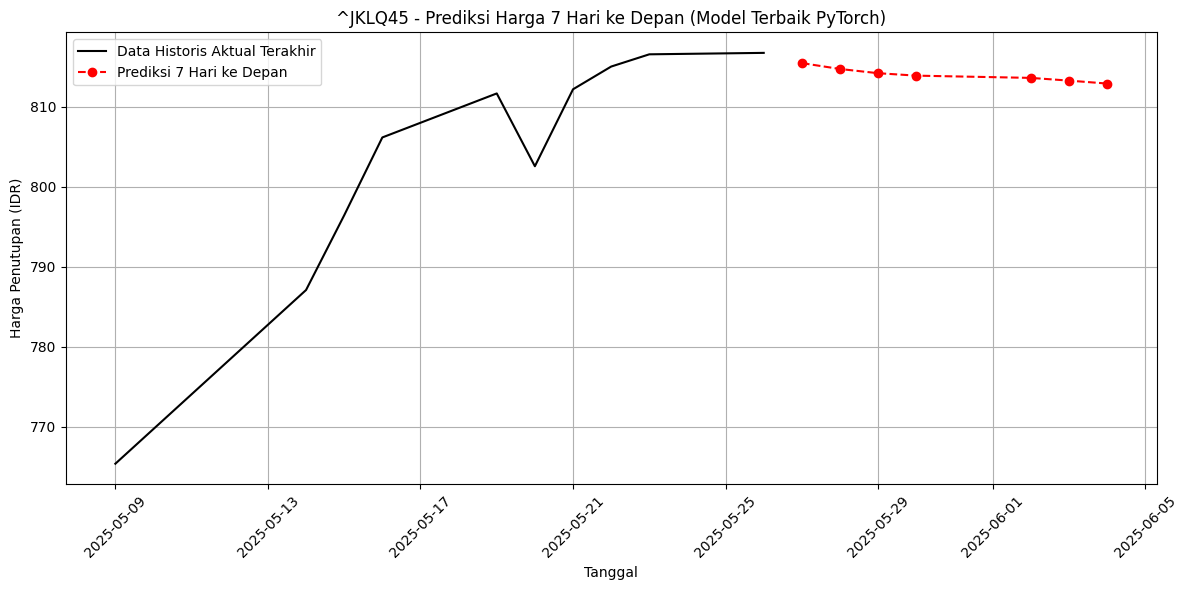

In [ ]:
# CELL BARU: PREDIKSI 7 HARI KE DEPAN DENGAN MODEL TERBAIK (PYTORCH)

print("\n--- Prediksi 7 Hari ke Depan dengan Model Terbaik (PyTorch) ---")

if not results_df_final_pt.empty:
    # Ambil parameter model terbaik dari hasil tuning
    best_params_row_pt = results_df_final_pt.sort_values('test_rmse').iloc[0]
    best_ws_pt = int(best_params_row_pt['window_size'])
    best_bs_pt = int(best_params_row_pt['batch_size']) # Mungkin tidak terlalu relevan untuk load model, tapi untuk konsistensi nama file
    best_ep_set_pt = int(best_params_row_pt['epochs_set'])
    best_lr_pt = best_params_row_pt['learning_rate']

    print(f"Menggunakan model terbaik dengan parameter:")
    print(f"  Window Size: {best_ws_pt}, Batch Size: {best_bs_pt}, Epochs Set: {best_ep_set_pt}, Learning Rate: {best_lr_pt}")

    # 1. Muat ulang scaler yang sesuai dengan window size terbaik
    #    Kita perlu menjalankan bagian dari prepare_data untuk mendapatkan scaler yang benar
    #    atau menyimpan scaler saat tuning (cara lebih advance)
    #    Untuk kesederhanaan, kita panggil ulang prepare_data hanya untuk mendapatkan scaler dan data terakhir

    print(f"  Memuat ulang data dan scaler untuk window_size: {best_ws_pt}...")
    (
        _, _,
        _, _,
        x_test_for_pred, y_test_for_pred, # Kita hanya butuh data test terakhir dan scaler
        scaler_best_model,
        _, _, test_df_for_pred # test_df untuk mengambil data aktual terakhir
    ) = prepare_data_pytorch(KODE_INDEKS, PERIODE_AWAL, PERIODE_AKHIR, best_ws_pt, TRAIN_RATIO, VAL_RATIO)

    # 2. Muat model terbaik
    best_model_filename_pt = os.path.join(output_dir_pt, f'best_model_pt_w{best_ws_pt}_b{best_bs_pt}_e{best_ep_set_pt}_lr{str(best_lr_pt).replace(".", "")}.pth')

    if os.path.exists(best_model_filename_pt):
        print(f"  Memuat model dari: {best_model_filename_pt}")
        # Buat instance model dengan arsitektur yang sama
        model_to_predict, _, _, _ = create_pytorch_model(
            best_ws_pt, best_lr_pt, GRU_UNITS_PYTORCH, DENSE_UNITS_PYTORCH, DROPOUT_RATE_PYTORCH, N_FEATURES
        )
        model_to_predict.load_state_dict(torch.load(best_model_filename_pt, map_location=device)) # map_location untuk fleksibilitas
        model_to_predict.to(device)
        model_to_predict.eval() # Set ke mode evaluasi

        # 3. Siapkan sekuens input terakhir dari data aktual
        # Kita butuh 'test_scaled' dari pemanggilan prepare_data di atas
        # Jika prepare_data mengembalikan x_test_seq, y_test_seq, scaler_obj, dan dataframe
        # kita perlu mendapatkan data test yang sudah di-scale untuk sekuens terakhir

        # Mengambil data test yang sudah di-scale dari prepare_data_pytorch
        # Untuk prediksi masa depan, kita butuh WINDOW_SIZE data terakhir dari KESELURUHAN DATASET yang sudah di-scale
        # Jadi kita perlu scale ulang seluruh dataset lq45 (jika scaler tidak disimpan per window size)
        # ATAU, lebih baik, kita ambil data terakhir dari test_set_scaled yang sesuai dengan window_size model terbaik

        # Ambil data mentah dari yfinance lagi untuk memastikan kita punya data paling akhir sebelum periode prediksi
        full_data_for_scaling = yf.download(KODE_INDEKS, start=PERIODE_AWAL, end=PERIODE_AKHIR, progress=False)[['Close']].copy()
        full_data_for_scaling.dropna(inplace=True)

        # Scale seluruh data dengan scaler yang DILATIH PADA TRAINING SET DARI KOMBINASI TERBAIK
        # Ini penting. Scaler harus konsisten.
        # Kita perlu `train_data_df` dari `prepare_data_pytorch` untuk `best_ws_pt` untuk me-fit scaler dengan benar.

        # Untuk mendapatkan scaler yang benar-benar digunakan untuk melatih model terbaik:
        # Kita butuh data training yang digunakan saat model terbaik dilatih.
        # Solusi sementara: panggil prepare_data lagi dengan parameter terbaik (agak redundan tapi memastikan scaler benar)

        (_, _, _, _, _, _, scaler_best_run,
        train_df_best_run, _, test_df_best_run) = prepare_data_pytorch(
            KODE_INDEKS, PERIODE_AWAL, PERIODE_AKHIR,
            best_ws_pt, TRAIN_RATIO, VAL_RATIO
        )

        # Ambil WINDOW_SIZE data terakhir dari KESELURUHAN dataset (yang sudah di-dropna)
        last_window_data_actual = full_data_for_scaling['Close'].values[-best_ws_pt:]
        last_window_data_scaled = scaler_best_run.transform(last_window_data_actual.reshape(-1, 1))

        # 4. Lakukan prediksi iteratif untuk 7 hari ke depan
        n_future_preds = 7
        future_predictions_list_scaled = []

        current_sequence_scaled = torch.tensor(last_window_data_scaled, dtype=torch.float32).reshape(1, best_ws_pt, N_FEATURES).to(device)

        with torch.no_grad():
            for _ in range(n_future_preds):
                next_pred_scaled_tensor = model_to_predict(current_sequence_scaled) # Shape (1,1)
                future_predictions_list_scaled.append(next_pred_scaled_tensor.cpu().item())

                # Update sekuens: buang data tertua, tambahkan prediksi baru
                # next_pred_scaled_tensor perlu di-reshape dan dipastikan ada di device yang sama
                next_pred_for_seq = next_pred_scaled_tensor.reshape(1, 1, N_FEATURES)
                current_sequence_scaled = torch.cat((current_sequence_scaled[:, 1:, :], next_pred_for_seq), dim=1)

        future_predictions_unscaled = scaler_best_run.inverse_transform(np.array(future_predictions_list_scaled).reshape(-1, 1))

        # 5. Tampilkan hasil prediksi (angka)
        print(f"\nPrediksi harga penutupan {KODE_INDEKS} untuk {n_future_preds} hari trading ke depan:")
        last_actual_date = full_data_for_scaling.index[-1]
        future_pred_dates = pd.date_range(start=last_actual_date + timedelta(days=1), periods=n_future_preds, freq='B') # 'B' untuk business day

        for i in range(n_future_preds):
            print(f"  {future_pred_dates[i].strftime('%Y-%m-%d')}: IDR {future_predictions_unscaled[i,0]:.2f}")

        # 6. Plot hasil prediksi
        plt.figure(figsize=(12, 6))
        # Ambil data aktual terakhir untuk konteks plot
        actual_data_for_plot = full_data_for_scaling['Close'].iloc[-best_ws_pt*2:] # Ambil 2x window size data aktual terakhir

        plt.plot(actual_data_for_plot.index, actual_data_for_plot.values, label='Data Historis Aktual Terakhir', color='black')
        plt.plot(future_pred_dates, future_predictions_unscaled, label=f'Prediksi {n_future_preds} Hari ke Depan', color='red', linestyle='--', marker='o')

        plt.title(f'{KODE_INDEKS} - Prediksi Harga {n_future_preds} Hari ke Depan (Model Terbaik PyTorch)')
        plt.xlabel('Tanggal')
        plt.ylabel('Harga Penutupan (IDR)')
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir_pt, f'future_prediction_plot_{n_future_preds}days_best_model_pt.png'))
        plt.show()

    else:
        print(f"File model terbaik {best_model_filename_pt} tidak ditemukan. Tidak dapat melakukan prediksi masa depan.")
else:
    print("Tidak ada hasil tuning yang tersimpan, tidak dapat melakukan prediksi masa depan.")

In [ ]:
# Buat cell baru di notebook-mu untuk membaca dan menampilkan CSV
import pandas as pd
import os

# Sesuaikan nama direktori dan file jika berbeda
output_dir_pt = "tuning_outputs_pytorch"
csv_filename = "gru_pytorch_tuning_results_simple_sorted.csv" # Coba yang sorted dulu
# Jika tidak ada, coba yang unsorted:
# csv_filename = "gru_pytorch_tuning_results_simple.csv"

file_path = os.path.join(output_dir_pt, csv_filename)

if os.path.exists(file_path):
    results_from_csv = pd.read_csv(file_path)
    print(f"Hasil dari file: {file_path}")
    print(results_from_csv)

    # Kamu juga bisa langsung menampilkan parameter terbaik dari CSV ini
    if not results_from_csv.empty:
        # Jika file sorted yang dibaca, baris pertama adalah yang terbaik berdasarkan test_rmse
        # Jika file unsorted, kamu perlu sort dulu
        if 'sorted' in csv_filename:
            best_params_from_csv = results_from_csv.iloc[0]
        else:
            best_params_from_csv = results_from_csv.sort_values('test_rmse').iloc[0]

        print("\n--- Parameter Model Terbaik dari CSV ---")
        print(f"Learning Rate  : {best_params_from_csv['learning_rate']}")
        print(f"Window Size    : {best_params_from_csv['window_size']}")
        print(f"Batch Size     : {best_params_from_csv['batch_size']}")
        print(f"Epochs Set     : {best_params_from_csv['epochs_set']}")
        print("\n--- Metrik Model Terbaik dari CSV ---")
        print(f"Test RMSE : {best_params_from_csv['test_rmse']:.2f}")
        print(f"Test MAPE : {best_params_from_csv['test_mape']:.2f}%")
    else:
        print("File CSV kosong.")
else:
    print(f"File CSV '{file_path}' tidak ditemukan. Pastikan loop tuning sudah berjalan dan menyimpan hasilnya.")

Hasil dari file: tuning_outputs_pytorch\gru_pytorch_tuning_results_simple_sorted.csv
    learning_rate  window_size  batch_size  epochs_set  test_rmse  test_mape
0          0.0010            5           8         200   9.801390   0.840887
1          0.0010            5          16         100   9.892324   0.864976
2          0.0010           10          16         100  10.736767   0.950933
3          0.0010           10          32         100  11.024389   0.978892
4          0.0001           10           8         200  11.526309   1.029271
5          0.0010           10          64         150  12.602544   1.135396
6          0.0010           10           8         200  13.003672   1.204579
7          0.0010            5          64         100  13.054867   1.167247
8          0.0010            5          16         150  13.634787   1.212623
9          0.0010           10          64         100  13.731702   1.261389
10         0.0001            5          32         100  13.734811   